In [36]:
import baostock as bs
import pandas as pd
import talib as ta
import matplotlib.pyplot as plt

rsiOverBuy = 80
rsiOverSell = 20
rsiMiddle = 50

##
#  下载日K线数据
#  code 股票代码
#  startDate 起始时间
#  endDate   结束时间
#
def downloadDailyStockKline(bsClient, code, startdate, enddate):
    #### 获取沪深A股历史K线数据 ####
    # 详细指标参数，参见“历史行情指标参数”章节；“分钟线”参数与“日线”参数不同。
    # 分钟线指标：date,time,code,open,high,low,close,volume,amount,adjustflag
    rs = bsClient.query_history_k_data_plus(code,
        "date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradeStatus,pctChg,isST",
        start_date=startdate, end_date=enddate,
        frequency="d", adjustflag="3")

    #### 打印结果集 ####
    data_list = []
    while (rs.error_code == '0') & rs.next():
        # 获取一条记录，将记录合并在一起
        data_list.append(rs.get_row_data())
    result = pd.DataFrame(data_list, columns=rs.fields)

    # 剔除停盘数据
    df_status = result[result['tradeStatus'] == '1']

    df_status['close'] = df_status['close'].astype(float)
    
    return df_status

def computeRSI(klineDataFrame):

    rsi_12days = ta.RSI(klineDataFrame['close'],timeperiod=12)
    rsi_6days = ta.RSI(klineDataFrame['close'],timeperiod=6)
    rsi_24days = ta.RSI(klineDataFrame['close'],timeperiod=24)
    klineDataFrame['rsi_6days'] = rsi_6days
    klineDataFrame['rsi_12days'] = rsi_12days
    klineDataFrame['rsi_24days'] = rsi_24days
    ##添加参考线位置
    klineDataFrame['overBuy'] = rsiOverBuy
    klineDataFrame['overSell'] = rsiOverSell
    klineDataFrame['middle'] = rsiMiddle

    # RSI超卖和超买
    rsi_buy_position = klineDataFrame['rsi_6days'] > rsiOverBuy
    rsi_sell_position = klineDataFrame['rsi_6days'] < rsiOverSell
    klineDataFrame.loc[rsi_buy_position[(rsi_buy_position == True) & (rsi_buy_position.shift() == False)].index, '超买'] = '超买'
    klineDataFrame.loc[rsi_sell_position[(rsi_sell_position == True) & (rsi_sell_position.shift() == False)].index, '超卖'] = '超卖'
    return klineDataFrame

    

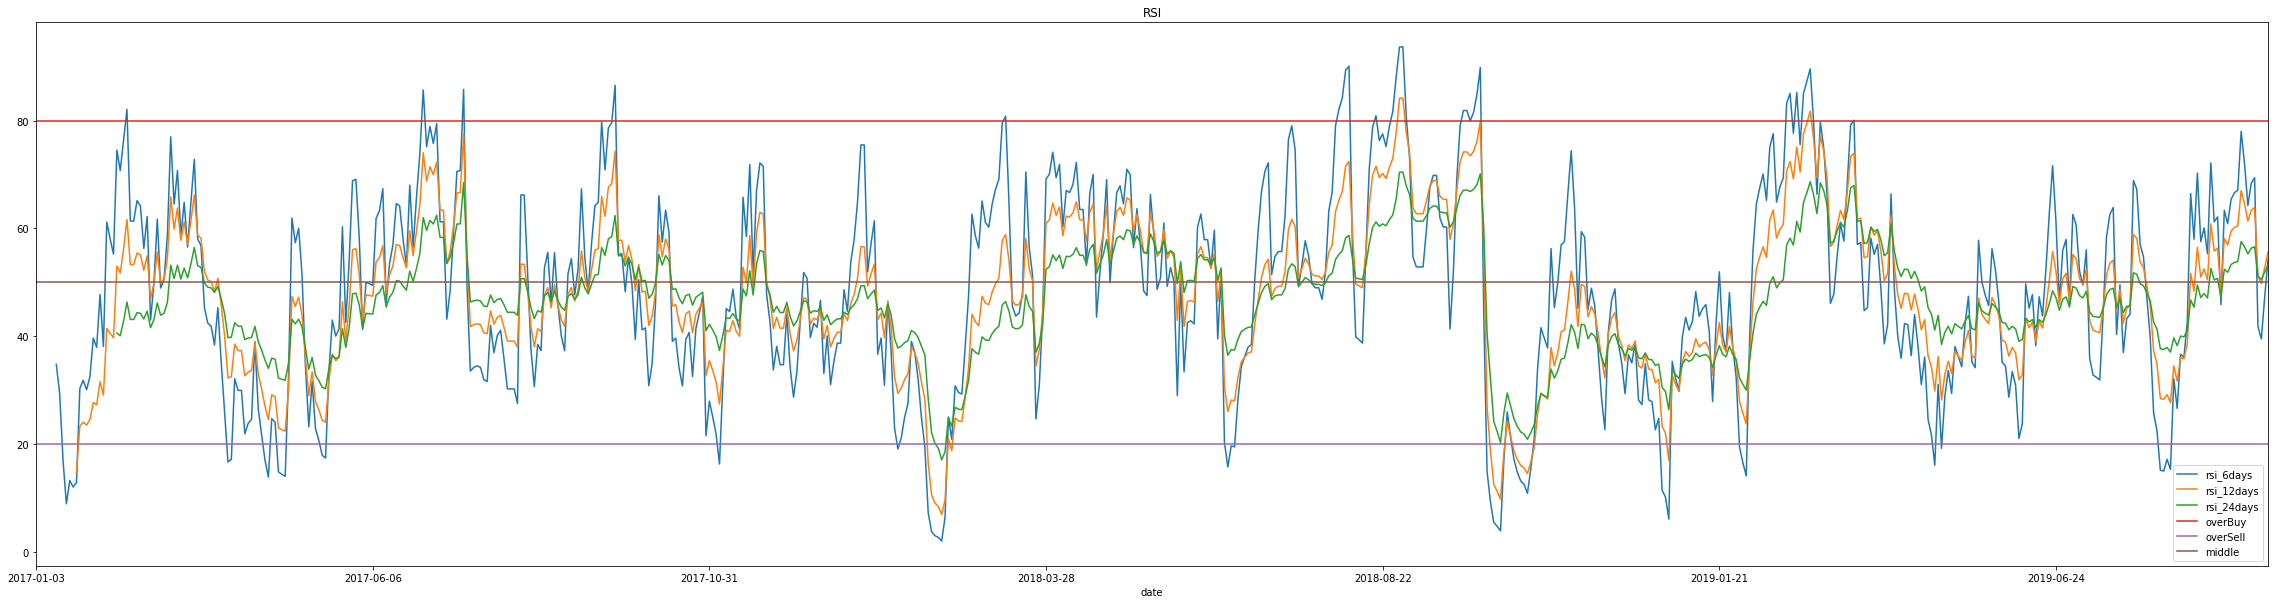

In [38]:
if __name__ == '__main__':
    code = "sz.002030"
    startDate = "2017-01-01"
    endDate = "2019-09-20"
    ## 下载数据
#     bs.login()
#     df = downloadDailyStockKline(bs, code, startDate, endDate)
#     bs.logout()
#     df.to_csv("/Users/matt/Documents/pythonworkspace/dailyKline.csv", encoding='utf_8_sig')
    
    df = pd.read_csv("/Users/matt/Documents/pythonworkspace/dailyKline.csv")
    ## 计算开始
    rsi = computeRSI(df)
    df2 = rsi[['date','rsi_6days','rsi_12days','rsi_24days','overBuy','overSell','middle']]

    df2.index = rsi['date']
    plot = df2.plot(title='RSI', figsize=(40,10))
#     plt.show()
    fig = plot.get_figure() 
    fig.savefig('/Users/matt/Downloads/rsi.png')
    rsi.to_csv("/Users/matt/Documents/pythonworkspace/rsi.csv",encoding='utf_8_sig')
    